In [8]:
# ============================================================
# Notebook setup
# ============================================================

%load_ext autoreload
%autoreload 2

# Control figure size
interactive_figures = False
if interactive_figures:
    # Normal behavior
    %matplotlib widget
    figsize=(9, 3)
else:
    # PDF export behavior
    figsize=(14, 4)

from util import util
import os
import pandas as pd
import numpy as np

# Load data
data_file = os.path.join('..', 'data', 'er.csv')
#data = util.load_ed_data(data_file)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Emergency Deparment Management Problems

## Emergency Room @ Maggiore Hospital

**We will now consider a problem from the healthcare sector**

We will use a dataset for the "Maggiore" hospital in Bologna

<center><img src="assets/maggiore.jpg" width="65%"/></center>

* In particular, we will focus on predicting arrivals
* ...To the Emergency Department (Pronto Soccorso)

## A Look at the Dataset

**We will start as usual by having a look at the dataset**

In [9]:
data = util.load_ed_data(data_file)
data

,year,ID,Triage,TkCharge,Code,Outcome
0,2018,1,2018-01-01 00:17:33,2018-01-01 04:15:36,green,admitted
1,2018,2,2018-01-01 00:20:33,2018-01-01 03:14:19,green,admitted
2,2018,3,2018-01-01 00:47:59,2018-01-01 04:32:30,white,admitted
51238,2018,51239,2018-01-01 00:49:51,NaT,white,abandoned
51240,2018,51241,2018-01-01 01:00:40,NaT,green,abandoned
...,...,...,...,...,...,...
95665,2019,95666,2019-10-31 23:26:54,2019-10-31 23:41:13,yellow,admitted
95666,2019,95667,2019-10-31 23:46:43,2019-11-01 09:30:25,green,admitted
108622,2019,108623,2019-10-31 23:54:05,NaT,green,abandoned
95667,2019,95668,2019-10-31 23:55:32,2019-11-01 00:18:46,yellow,admitted


## A Look at the Dataset

In [10]:
data.iloc[:3]

,year,ID,Triage,TkCharge,Code,Outcome
0,2018,1,2018-01-01 00:17:33,2018-01-01 04:15:36,green,admitted
1,2018,2,2018-01-01 00:20:33,2018-01-01 03:14:19,green,admitted
2,2018,3,2018-01-01 00:47:59,2018-01-01 04:32:30,white,admitted


* Each row refers to a single patient
* `Triage` is the arrival time of each patient
* `TKCharge` is the time when a patient starts the first visit
* `Code` refers to the estimated priority (white < green < yellow < red)
* `Outcome` discriminates some special conditions (people quitting, fast tracks)

## A Look at the Dataset

**Let's also have a look at the data types**

In [11]:
data.dtypes

year                 int64
ID                   int64
Triage      datetime64[ns]
TkCharge    datetime64[ns]
Code              category
Outcome           category
dtype: object

**As we said, we will focus for on _predicting arrivals_**

...Hence, it makes sense to sort rows by increasing triage time:

In [12]:
data.sort_values(by='Triage', inplace=True)

## Inter-Arrival Times

**Let's check empirically the distribution of the inter-arrival times**

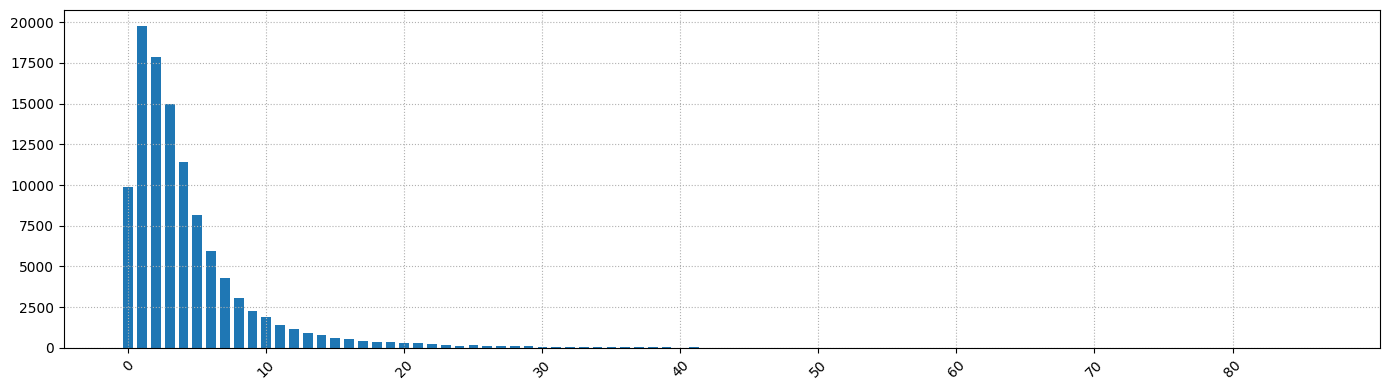

In [15]:
delta = data['Triage'].iloc[1:].round('2min') - data['Triage'].iloc[:-1].round('2min').values
tmp = delta.value_counts().sort_index().values
tmp = pd.Series(index=np.arange(len(tmp)), data=tmp)
util.plot_bars(tmp, tick_gap=10, figsize=figsize)

* There is a number of very low inter-arrival times
* This is due to how triage is performed (bursts, rather than a steady flow)

## Waiting Time

**Here is the distribution of the waiting times**

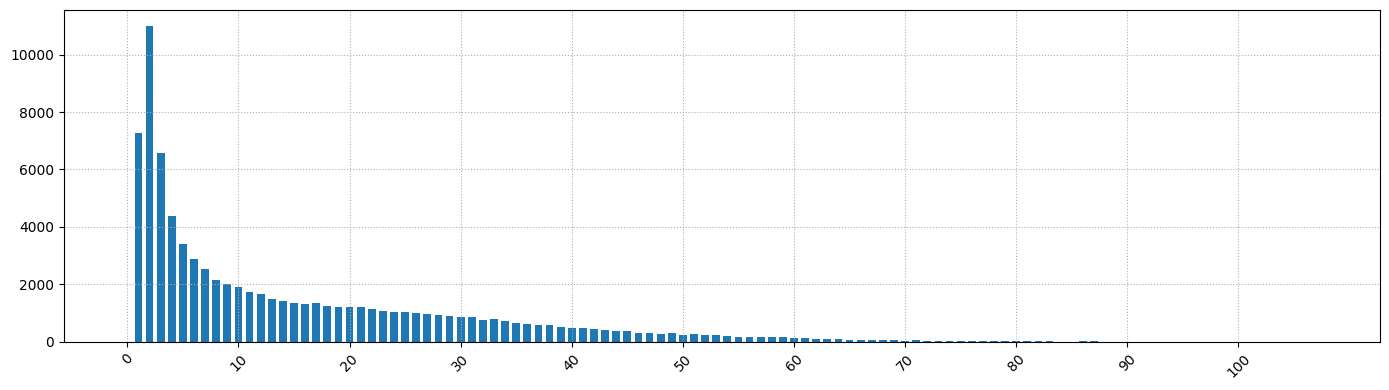

In [16]:
tmp = data[~data['TkCharge'].isnull()]
wait_time = tmp['TkCharge'].round('10min') - tmp['Triage'].round('10min')
tmp = wait_time.value_counts().sort_index().values
tmp = pd.Series(index=np.arange(len(tmp)), data=tmp)
util.plot_bars(tmp, tick_gap=10, figsize=figsize)

* The distritbution is _heavy-tailed_
* I.e. the probability of very long waiting times is non-negligible

## Code Distribution

**The distribution of the priority codes**

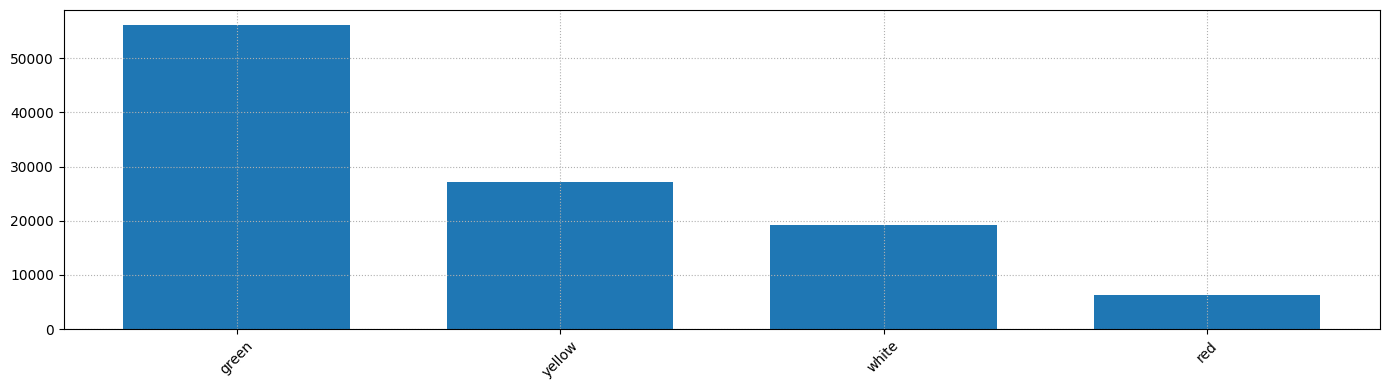

In [17]:
util.plot_bars(data['Code'].value_counts(), figsize=figsize)

* Green code (low severity) form the majority of arrivals
* Yellow and red codes (mid and high severity) are in smaller numbers
* White codes (lowest priority) are also not very frequent

## Outcome Distribution

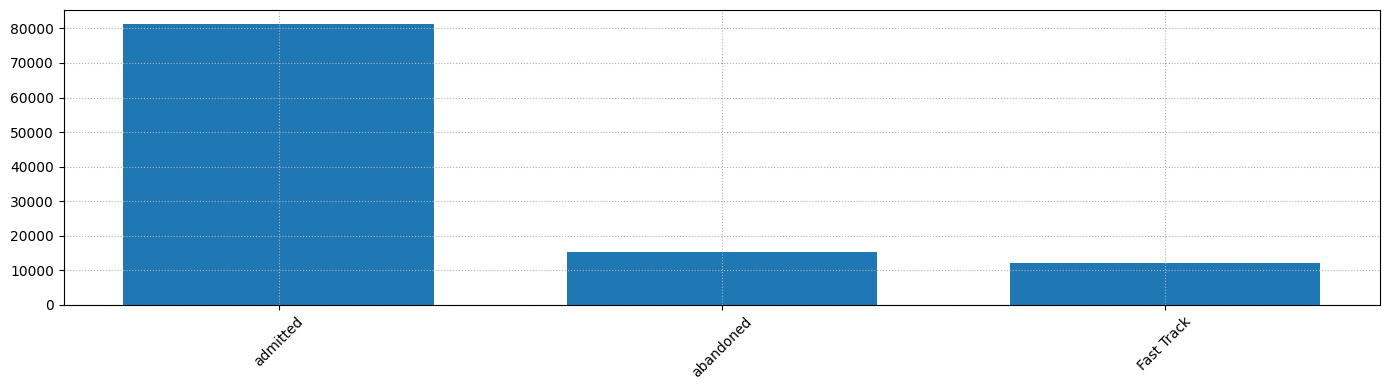

In [18]:
util.plot_bars(data['Outcome'].value_counts(), figsize=figsize)

* Abandons are infrequent, as are "fast track" patients

## Arrival Distribution over Months

**Let's look at the arrival distribution over months**

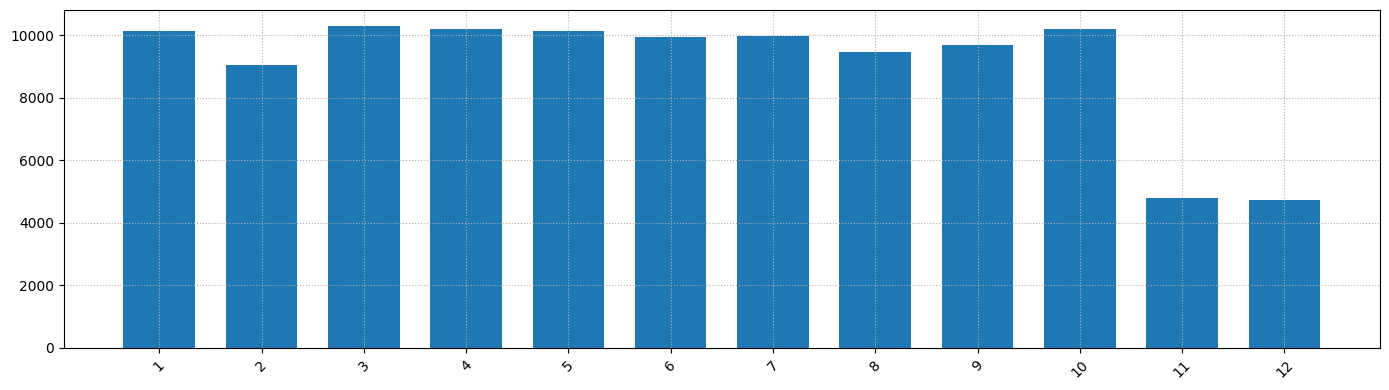

In [19]:
months = data['Triage'].dt.month
util.plot_bars(months.value_counts().sort_index(), figsize=figsize)

* The low values for Nov. and Dec. are due to the 2019 series ending in October
* The distribution seems stable (but we are not plotting standard deviations!)

## Arrival Distribution over Weekdays

**Let's look at the distribution over weekdays**

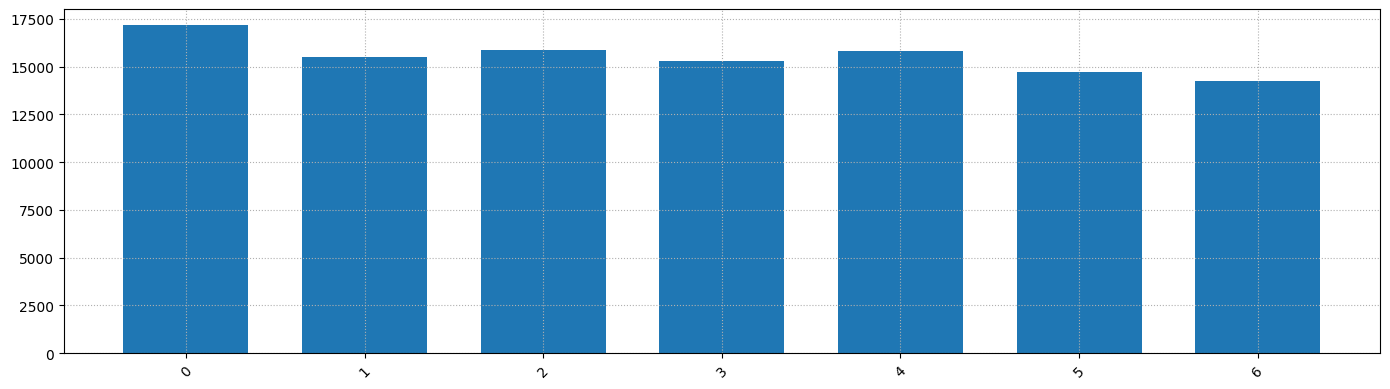

In [20]:
weekdays = data['Triage'].dt.weekday
util.plot_bars(weekdays.value_counts().sort_index(), figsize=figsize)

* Similarly to months, weekdays are likelly to have little predictive power
* ...But it's better not to rush conclusions (we still are not plotting the stddev!)

## Arrival Distribution over Hours

**Let's see now the arrival distribution over the hours of the day**

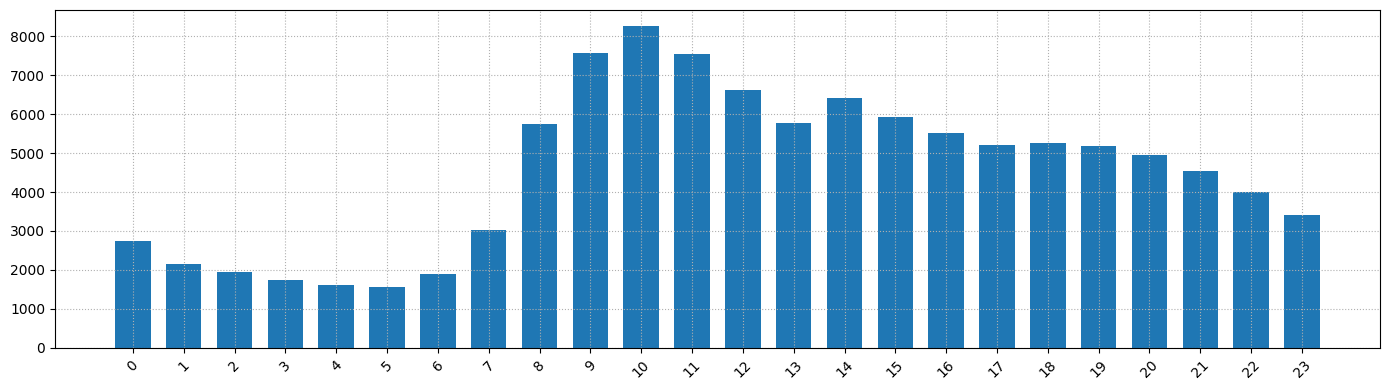

In [21]:
hours = data['Triage'].dt.hour
util.plot_bars(hours.value_counts().sort_index(), figsize=figsize)

* There is _a clear pattern_: the hour of the day will have strong predictive power
* Again, analyzing the standard deviation may provide better insights

# Data Preparation

## Binning

**In our considered problem:**

* We are not going to revise our decisions continuosly
* We are not interested in predicting the next arrival

Rather:

* We will take decisions _at fixed intervals_
* We care about the expected arrivals _in a given horizon_

**Overall, we need to choose _a meaningful time unit_**

In other words, we need to perform some kind of binning

* We used binning to downsample high-frequency data
* Here we will use binning to _aggregate events with a variable frequency_

## Code-Based Counts

**We will prepare the data to track counts for _all priority codes_**

In [22]:
codes = pd.get_dummies(data['Code'])
codes.set_index(data['Triage'], inplace=True)
codes.columns = codes.columns.to_list()
print(f'Number of examples: {len(codes)}')
codes.head()

Number of examples: 108625


,green,red,white,yellow
Triage,,,,
2018-01-01 00:17:33,1,0,0,0
2018-01-01 00:20:33,1,0,0,0
2018-01-01 00:47:59,0,0,1,0
2018-01-01 00:49:51,0,0,1,0
2018-01-01 01:00:40,1,0,0,0


* The `get_dummies` function applies a one-hot encoding to categorical value
* The method generates a categorial column index (then converted to list)

## Resampling

**Then, we need to aggregate data with a specified frequency**

In [23]:
codes_b = codes.resample('H').sum()
print(f'Number of examples: {len(codes_b)}')
codes_b.head()

Number of examples: 16056


,green,red,white,yellow
Triage,,,,
2018-01-01 00:00:00,2,0,2,0
2018-01-01 01:00:00,7,1,1,1
2018-01-01 02:00:00,4,1,4,3
2018-01-01 03:00:00,7,0,1,1
2018-01-01 04:00:00,3,0,2,0


* We used the `resample` iterator
* `resample` generater a dataframe with a _dense_ index
* We chose 1 hours are our time unit

## Computing Totals

**We also compute the total number of arrivals for each interval**

In [24]:
cols = ['white', 'green', 'yellow', 'red']
codes_b['total'] = codes_b[cols].sum(axis=1)
codes_b

,green,red,white,yellow,total
Triage,,,,,
2018-01-01 00:00:00,2,0,2,0,4
2018-01-01 01:00:00,7,1,1,1,10
2018-01-01 02:00:00,4,1,4,3,12
2018-01-01 03:00:00,7,0,1,1,9
2018-01-01 04:00:00,3,0,2,0,5
...,...,...,...,...,...
2019-10-31 19:00:00,3,1,0,4,8
2019-10-31 20:00:00,9,0,2,0,11
2019-10-31 21:00:00,3,0,0,2,5


* The total count will be less noisy, if the individual terms are independent

## Adding Time Information

**Finally, we add time information (for later convenience)**

In [25]:
codes_bt = codes_b.copy()
codes_bt['month'] = codes_bt.index.month
codes_bt['weekday'] = codes_bt.index.weekday
codes_bt['hour'] = codes_bt.index.hour
codes_bt

,green,red,white,yellow,total,month,weekday,hour
Triage,,,,,,,,
2018-01-01 00:00:00,2,0,2,0,4,1,0,0
2018-01-01 01:00:00,7,1,1,1,10,1,0,1
2018-01-01 02:00:00,4,1,4,3,12,1,0,2
2018-01-01 03:00:00,7,0,1,1,9,1,0,3
2018-01-01 04:00:00,3,0,2,0,5,1,0,4
...,...,...,...,...,...,...,...,...
2019-10-31 19:00:00,3,1,0,4,8,10,3,19
2019-10-31 20:00:00,9,0,2,0,11,10,3,20
2019-10-31 21:00:00,3,0,0,2,5,10,3,21


## Counts over Time

**Our resampled series can be plotted easily over time**

Let's see the total counts as an example:

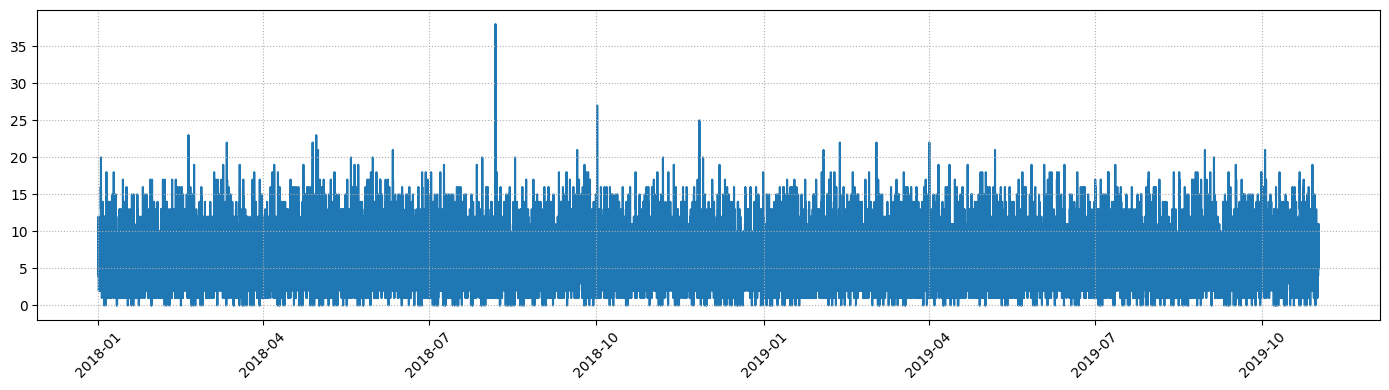

In [26]:
util.plot_series(codes_b['total'], figsize=figsize)

## Counts over Time

**Our resampled series can be plotted easily over time**

The same plot, for the red codes (the counts are significanly lower):

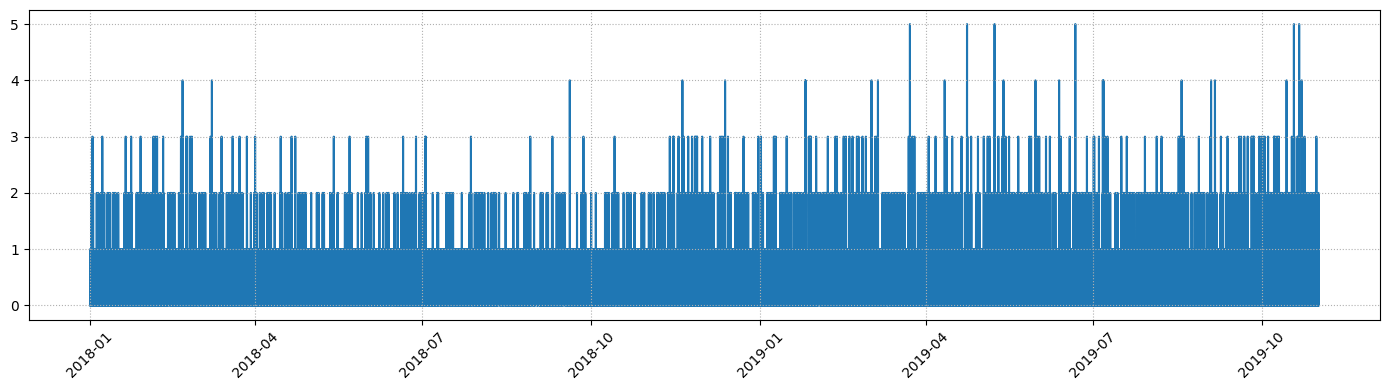

In [27]:
util.plot_series(codes_b['red'], figsize=figsize)

## Variability

**With our binned series, we can assess the count variability**

Let's check it over different months:

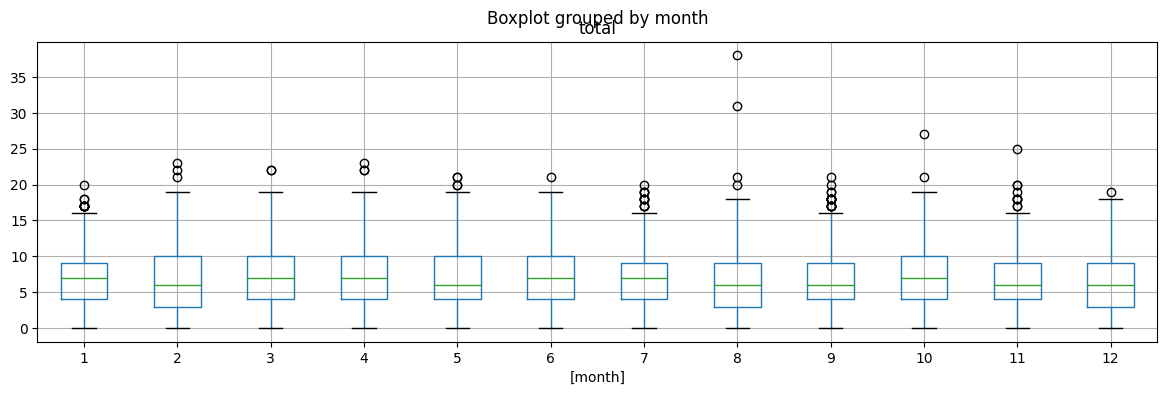

In [28]:
codes_bt[['month', 'total']].boxplot(by='month', figsize=figsize);

* The variability does not change much over different months

## Variability

**Here is the standard deviation over weekdays**

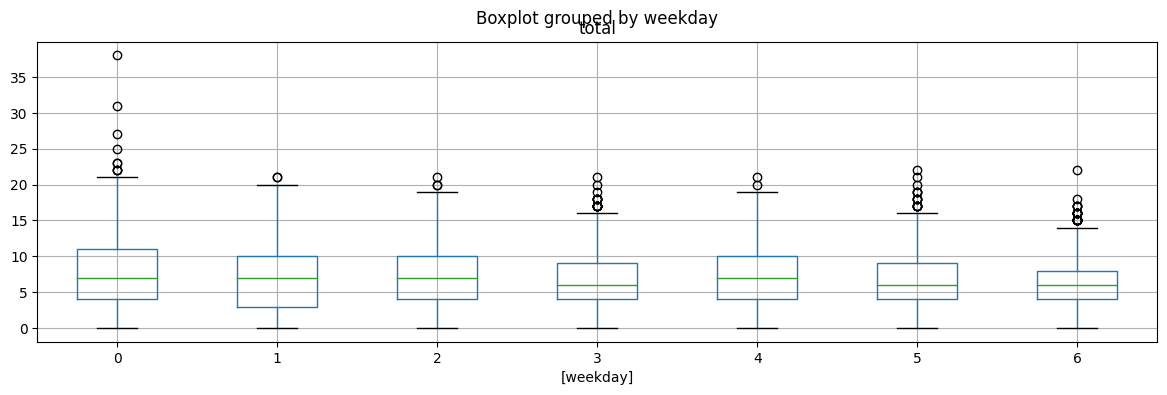

In [29]:
codes_bt[['weekday', 'total']].boxplot(by='weekday', figsize=figsize);

* There is a trend, but rather weak

## Variability

**...And finally over hours**

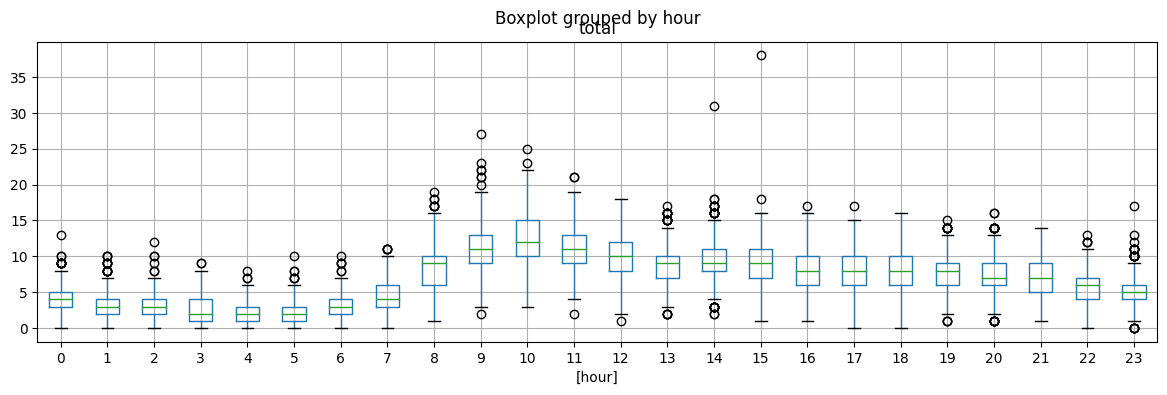

In [30]:
codes_bt[['hour', 'total']].boxplot(by='hour', figsize=figsize);

* Variance and mean seem to be quite correlated